# Problem Statement: 

The Rain in Australia dataset contains about 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:

![](https://i.imgur.com/5QNJvir.png)


As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

In [ ]:
# Download the Dataset from Kaggle
import opendatasets as od

od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')

Below code cell is same as my previous project `DecisionTree.ipynb`.
If you want to understand below code then go to:
[DecisionTree.ipynb](https://github.com/HirparaAmit/DecisionTree)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
from sklearn.tree import plot_tree, export_text
%matplotlib inline

raw_df = pd.read_csv('weatherAUS.csv')
raw_df.dropna(subset = ['RainTomorrow'],inplace=True)

year = pd.to_datetime(raw_df.Date).dt.year
train_df = raw_df[year<2015]
val_df = raw_df[year==2015]
test_df = raw_df[year>2015]

input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols]) 
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

X_train = train_inputs[numeric_cols+encoded_cols]
X_val = val_inputs[numeric_cols+encoded_cols]
X_test = test_inputs[numeric_cols+encoded_cols]

C:\Users\hirpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
C:\Users\hirpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
C:\Users\hirpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

# Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model.

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

!["Photo](15.png "Title")



A random forest works by averaging/combining the results of several decision trees:

!["Photo](16.png "Title")

We'll use the RandomForestClassifier class from sklearn.ensemble.

In [3]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1, random_state=42)

model.fit(X_train, train_targets)

model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9999494888269285, 0.8566537055307295)

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

!["Photo](17.png "Title")

We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [4]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

We can access individual decision trees using model.estimators_

In [7]:
print(len(model.estimators_))

model.estimators_[0]

100


DecisionTreeClassifier(max_features='auto', random_state=1608637542)

[Text(2232.0, 951.3000000000001, 'Sunshine <= 0.403\ngini = 0.347\nsamples = 62607\nvalue = [76887, 22101]\nclass = No'),
 Text(1116.0, 679.5, 'Pressure9am <= 0.609\ngini = 0.499\nsamples = 11288\nvalue = [9272, 8542]\nclass = No'),
 Text(558.0, 407.70000000000005, 'Cloud9am <= 0.833\ngini = 0.475\nsamples = 6067\nvalue = [3702, 5808]\nclass = Yes'),
 Text(279.0, 135.89999999999998, '\n  (...)  \n'),
 Text(837.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1674.0, 407.70000000000005, 'WindGustDir_NNE <= 0.5\ngini = 0.442\nsamples = 5221\nvalue = [5570, 2734]\nclass = No'),
 Text(1395.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1953.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3348.0, 679.5, 'RainToday_Yes <= 0.5\ngini = 0.278\nsamples = 51319\nvalue = [67615, 13559]\nclass = No'),
 Text(2790.0, 407.70000000000005, 'Pressure9am <= 0.521\ngini = 0.207\nsamples = 41960\nvalue = [58514, 7796]\nclass = No'),
 Text(2511.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3069.0, 135.89999999

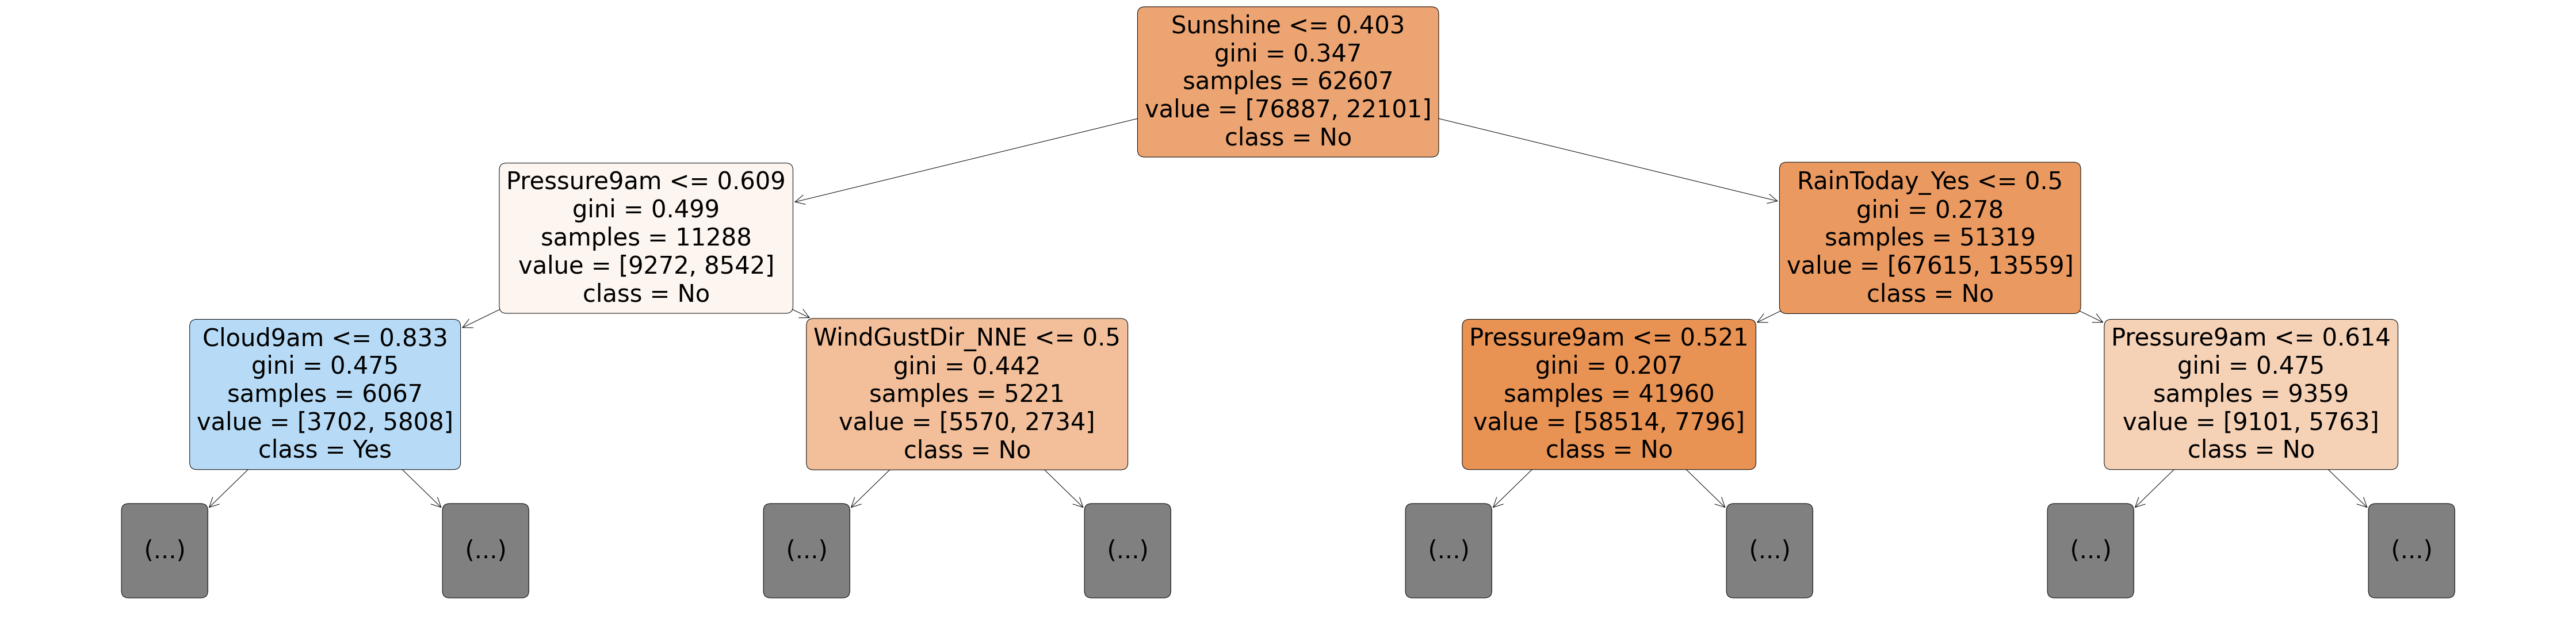

In [9]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_)

[Text(2232.0, 951.3000000000001, 'Sunshine <= 0.417\ngini = 0.349\nsamples = 62448\nvalue = [76707, 22281]\nclass = No'),
 Text(1116.0, 679.5, 'Humidity3pm <= 0.745\ngini = 0.499\nsamples = 11821\nvalue = [9860, 8914]\nclass = No'),
 Text(558.0, 407.70000000000005, 'Humidity3pm <= 0.625\ngini = 0.45\nsamples = 7988\nvalue = [8315, 4320]\nclass = No'),
 Text(279.0, 135.89999999999998, '\n  (...)  \n'),
 Text(837.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1674.0, 407.70000000000005, 'WindGustSpeed <= 0.217\ngini = 0.377\nsamples = 3833\nvalue = [1545, 4594]\nclass = Yes'),
 Text(1395.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1953.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3348.0, 679.5, 'Location_MountGinini <= 0.5\ngini = 0.278\nsamples = 50627\nvalue = [66847, 13367]\nclass = No'),
 Text(2790.0, 407.70000000000005, 'Location_Moree <= 0.5\ngini = 0.273\nsamples = 49365\nvalue = [65436, 12778]\nclass = No'),
 Text(2511.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3069.0, 1

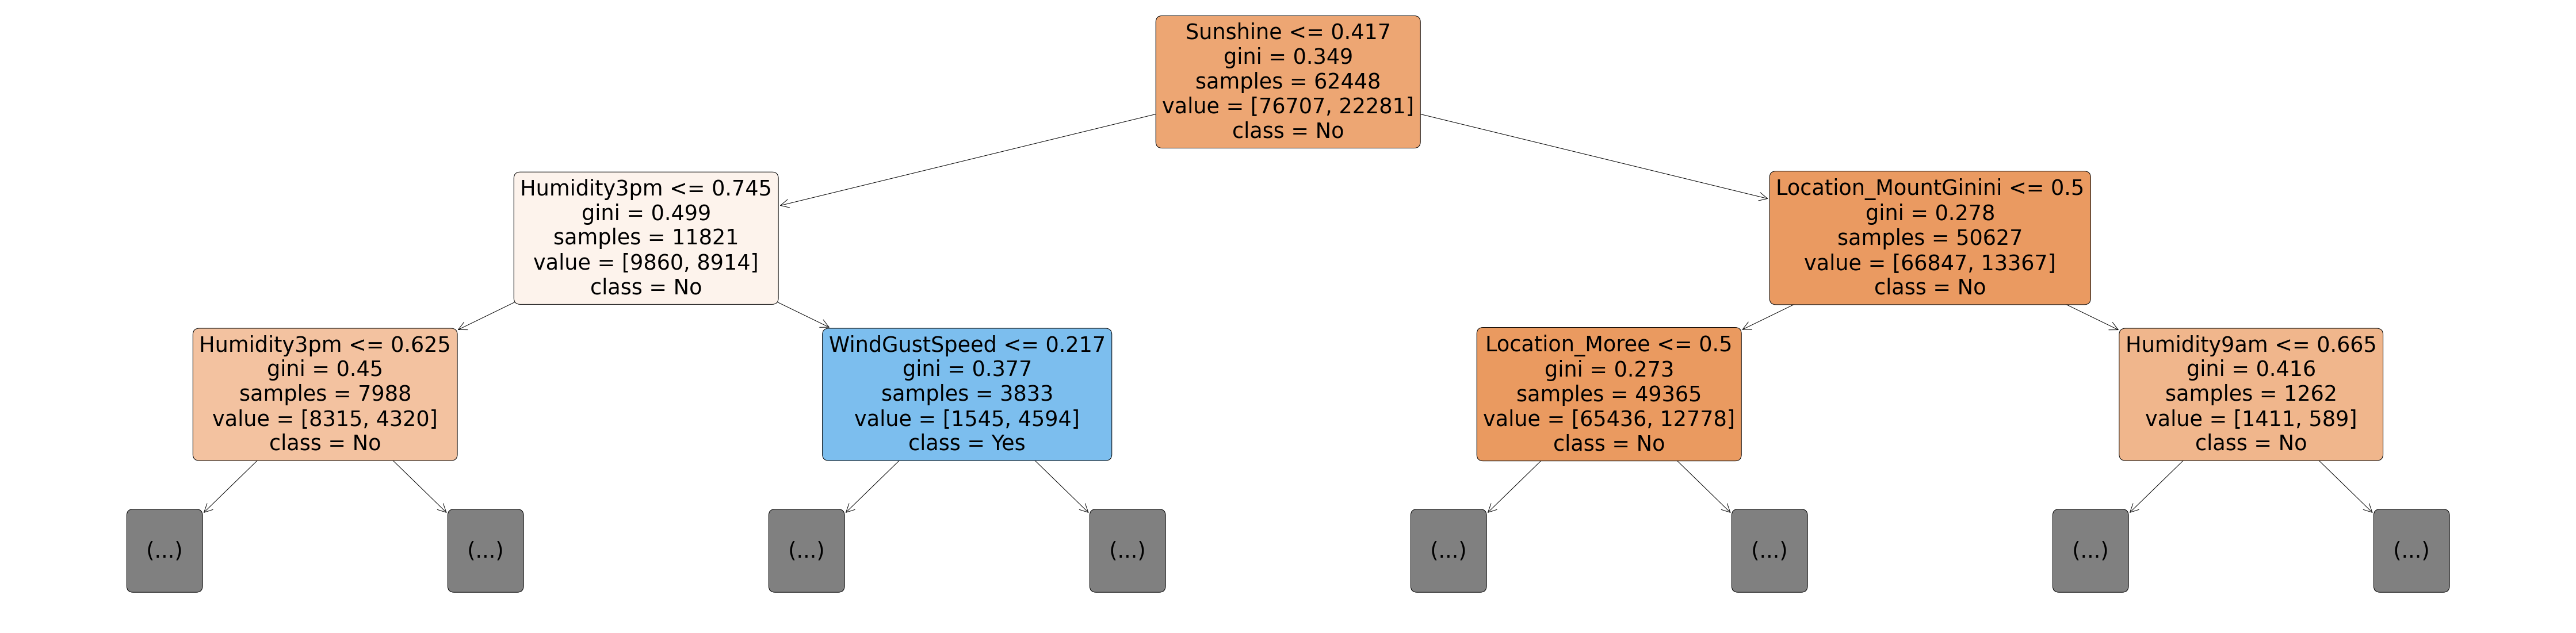

In [10]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[15], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_)

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [12]:
importance_df = pd.DataFrame({
    'feature' : X_train.columns,
    'importance' : model.feature_importances_
}).sort_values('importance',ascending=False)
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.139904
4,Sunshine,0.053696
11,Pressure3pm,0.052713
8,Humidity9am,0.050051
2,Rainfall,0.048077
10,Pressure9am,0.047944
5,WindGustSpeed,0.047477
15,Temp3pm,0.044379
1,MaxTemp,0.041865
0,MinTemp,0.041199


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

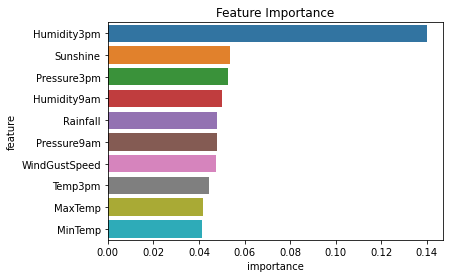

In [14]:
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x='importance', y='feature')

# Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees.

Let's create a base model with which we can compare models with tuned hyperparameters.

In [16]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

base_train_acc = model.score(X_train,train_targets)
base_val_acc = model.score(X_val,val_targets)
base_train_acc, base_val_acc

(0.9999494888269285, 0.8566537055307295)

# `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed.

In [18]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10).fit(X_train,train_targets)

model.score(X_train,train_targets), model.score(X_val,val_targets)

(0.986958015112943, 0.8485868492832686)

In [19]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500).fit(X_train,train_targets)

model.score(X_train,train_targets), model.score(X_val,val_targets)

(0.9999797955307714, 0.8577563693343393)

In [33]:
def estimators(n):
    model = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=n).fit(X_train,train_targets)
    train_err = 1 - model.score(X_train,train_targets)
    val_err = 1 - model.score(X_val,val_targets)
    return {'n_estimators' : n, 'Training Error' : train_err, 'Validation Error' : val_err}

esti_df = pd.DataFrame([estimators(n) for n in range(50,200,30)])
esti_df

,n_estimators,Training Error,Validation Error
0,50,0.000354,0.143869
1,80,0.000071,0.142940
2,110,0.000040,0.143230
3,140,0.000020,0.142650
4,170,0.000020,0.143462


# `max_depth and max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a max_depth to reduce overfitting.

Let's define a helper function test_params to make it easy to test hyperparameters.

In [24]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42,n_jobs=-1,**params).fit(X_train,train_targets)
    return model.score(X_train,train_targets), model.score(X_val,val_targets)

Let's test the few values of max_depth and max_leaf_nodes

In [29]:
print(base_train_acc,base_val_acc)
test_params(max_depth=5)

0.9999494888269285 0.8566537055307295


(0.8197862367155615, 0.8240961058557251)

In [30]:
test_params(max_depth=26)

(0.9814826039519942, 0.8572340549010504)

In [31]:
test_params(max_leaf_nodes=2**5)

(0.8314341132258456, 0.833904010214149)

In [32]:
test_params(max_leaf_nodes=2**20)

(0.9999494888269285, 0.8556671116011839)

# `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [36]:
print(base_train_acc,base_val_acc)
test_params(max_features = 'log2')

0.9999494888269285 0.8566537055307295


(0.9999595910615429, 0.8558992513493123)

In [39]:
test_params(max_features = 3), test_params(max_features = 20)

((0.9999494888269285, 0.8543323080494458),
 (0.9999595910615429, 0.8565956705936975))

# `min_samples_split and min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [42]:
test_params(min_samples_split = 5, min_samples_leaf = 2)

(0.9573584676930537, 0.855144797167895)

In [43]:
test_params(min_samples_split = 100, min_samples_leaf = 60)

(0.8495676243585081, 0.8451047530613429)

# `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.

In [48]:
print(base_train_acc,base_val_acc)
test_params(min_impurity_decrease = 1e-6)

0.9999494888269285 0.8566537055307295


(0.9888168262819735, 0.8561313910974406)

In [46]:
test_params(min_impurity_decrease = 1e-2)

(0.774891906089627, 0.7882885497069235)

# `bootstrap` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.

<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [50]:
print(base_train_acc,base_val_acc)
test_params(bootstrap=False)

0.9999494888269285 0.8566537055307295


(0.9999797955307714, 0.8567697754047937)

# `max_samples`

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [51]:
test_params(max_samples = 0.9)

(0.9997676486038711, 0.8565376356566653)

# `class_weight`

In [54]:
print(base_train_acc,base_val_acc)
test_params(class_weight = 'balanced')

0.9999494888269285 0.8566537055307295


(0.9999494888269285, 0.8543903429864779)

In [55]:
test_params(class_weight = {'No' : 1,'Yes' : 2})

(0.9999595910615429, 0.8558412164122802)

# Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [56]:
model = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=500,max_features=7,max_depth=30,class_weight={'No':1,'Yes':1.5})

model.fit(X_train,train_targets)

print(base_train_acc,base_val_acc)
print(model.score(X_train,train_targets))
print(model.score(X_val,val_targets))

0.9999494888269285 0.8566537055307295
0.9920192346547057
0.8563054959085369


We've increased the accuracy from 84.5% with a single decision tree to 85.7% with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests), and we should try another modeling technique e.g. gradient boosting.

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

Finally, let's also compute the accuracy of our model on the test set.

In [57]:
model.score(X_test,test_targets)

0.8451913451913452

# Making Predictions on New Inputs

Let's define a helper function to make predictions on new inputs.

In [58]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols+encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred,prob

In [59]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(model,new_input)

C:\Users\hirpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


('Yes', 0.7608595348304203)